# **Visualize a prediction of the model**

#### Matplotlib backend

In [1]:
# For interactive plots (needs ipympl and ipywidgets)
# %matplotlib widget

# For static plots
%matplotlib inline

#### Imports

In [95]:
# Standard libraries
import pathlib
import sys

# Add the src directory to the system path
# (to avoid having to install project as a package)
sys.path.append("../src/")

# Third-party libraries
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import omegaconf

# Custom modules
from toolbox.modules.object_segmentation_prediction_module import (
    ObjectSegmentationPredictionModule,
    BatchInferenceData,
)
from toolbox.modules.probabilistic_segmentation_lookup import (
    ProbabilisticSegmentationLookup,
)
from toolbox.modules.probabilistic_segmentation_mlp import (
    ProbabilisticSegmentationMLP,
)
from toolbox.modules.simple_resnet_module import SimpleResNet
from toolbox.utils.partialclass import partialclass

## Instanciate the model and load pre-trained weights

In [96]:
runs_dir = pathlib.Path("../logs/train/runs")
checkpoint = None

if checkpoint is None:
    # Get the last checkpoint
    logs_dir = sorted(runs_dir.iterdir())[-1]
else:
    # Get the checkpoint with the specified name
    logs_dir = runs_dir / checkpoint

print(f"Loading checkpoint from {logs_dir}")

# Load the state_dict of the model from the checkpoint
train_module_state_dict = torch.load(logs_dir / "checkpoints/last.ckpt").get("state_dict")

Loading checkpoint from ../logs/train/runs/2024-06-13_06-41-21


In [97]:
# # Replace each prefix in the state_dict
# new_state_dict = {}
# for key, value in train_module_state_dict.items():
#     new_state_dict[key.replace("_model._probabilistic_segmentation_model._resnet18.", "")] = value

# # Save the new state_dict
# torch.save(new_state_dict, "../weights/resnet18.ckpt")

In [98]:
# Choose the probabilistic segmentation model to use
# probabilistic_segmentation_model = ProbabilisticSegmentationLookup(
#     color_space="rgb",
#     nb_bins=(32, 32, 32),
#     use_histograms=True,
#     output_logits=False,
# )

SimpleResNet34 = partialclass(
    SimpleResNet,
    version=34,
    nb_input_channels=4,
    output_logits=True,
)

probabilistic_segmentation_model = ProbabilisticSegmentationMLP(
    net_cls=SimpleResNet34,
    patch_size=5,
    output_logits=False,
)

In [99]:
# Instantiate the model used for prediction
prediction_module = ObjectSegmentationPredictionModule(
    probabilistic_segmentation_model=probabilistic_segmentation_model,
)

def match_state_dict(state_dict: dict, model: torch.nn.Module) -> dict:
    """Extract the state_dict of the model from an other state_dict by matching their
    keys.

    Args:
        state_dict (dict): The state_dict from which to extract the model's state_dict.
        model (torch.nn.Module): The model for which to extract the state_dict.

    Returns:
        dict: The state_dict of the model.
    """
    model_state_dict = model.state_dict()
    new_state_dict = {
        key: value
        for key, value in state_dict.items()
        if key in model_state_dict
    }
    
    model_state_dict.update(new_state_dict)
    
    return model_state_dict

# Get the state_dict of the model used for prediction from the pretrained model
prediction_module_state_dict = match_state_dict(
    train_module_state_dict,
    prediction_module,
)

# Load the state_dict into the model
prediction_module.load_state_dict(prediction_module_state_dict)

<All keys matched successfully>

## Load a sample image and set a bounding box

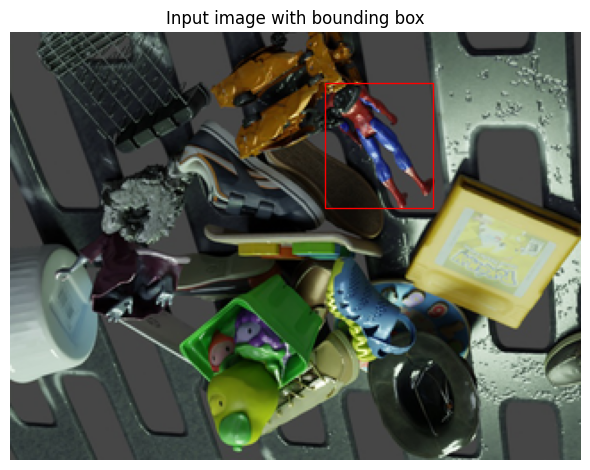

In [116]:
# Set the image to segment
# image = plt.imread("images/gso_bag.png")
# image = plt.imread("images/gso_bowl.png")
# image = plt.imread("images/gso_coffee.png")
# image = plt.imread("images/gso_dog_bowl.png")
# image = plt.imread("images/gso_jarro.png")
# image = plt.imread("images/gso_nips.png")
# image = plt.imread("images/gso_pikachu.png")
# image = plt.imread("images/gso_sheep.png")
# image = plt.imread("images/gso_skip.png")
image = plt.imread("images/gso_spiderman.png")

# Remove the alpha channel if it exists
if image.shape[-1] == 4:
    image = image[..., :3]

# Convert [0, 1] to [0, 255] and to uint8
image = (image * 255).astype(np.uint8)


# Set the bounding box of the object to segment
# bbox = [265, 190, 420, 335]  # cat (cat_rbot.png)
# bbox = [275, 80, 410, 190]  # horse (cat_rbot.png)
# bbox = [0, 260, 170, 400]  # glue gun (cat_rbot.png)

# bbox = [223, 68, 311, 185]  # bag (gso_bag.png)
# bbox = [49, 123, 112, 198]  # turquoise bowl (gso_bowl.png)
# bbox = [9, 154, 109, 210]  # coffee box (gso_coffee.png)
# bbox = [159, 0, 278, 110]  # dog bowl (gso_dog_bowl.png)
# bbox = [46, 58, 104, 148]  # jarro (gso_jarro.png)
# bbox = [4, 49, 133, 202]  # nips (gso_nips.png)
# bbox = [151, 0, 314, 70]  # pikachu (gso_pikachu.png)
# bbox = [106, 106, 225, 196]  # sheep (gso_sheep.png)
# bbox = [80, 45, 227, 192]  # skip (gso_skip.png)
bbox = [176, 28, 237, 98]  # spiderman (gso_spiderman.png)


# Draw the bounding box on the image
fig, ax = plt.subplots()
ax.imshow(image)
rect = patches.Rectangle(
    (bbox[0], bbox[1]),
    bbox[2] - bbox[0],
    bbox[3] - bbox[1],
    linewidth=1,
    edgecolor="r",
    facecolor="none",
)
ax.add_patch(rect)
ax.axis("off")
plt.title("Input image with bounding box")
plt.tight_layout()
plt.show()

## Construct the input data for the model

In [117]:
input = BatchInferenceData(
    rgbs=torch.tensor(image).permute(2, 0, 1).unsqueeze(0),
    contour_points_list=[
            # First example of the batch
            [np.array(bbox).reshape(-1, 2),],
            # Second example of the batch...
        ],
)

## Model prediction

In [118]:
# Set the device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

prediction_module = prediction_module.to(device)
input.rgbs = input.rgbs.to(device)

In [119]:
# Set the model to evaluation mode
prediction_module.eval()

ObjectSegmentationPredictionModule(
  (_model): ObjectSegmentationPredictionModel(
    (_mobile_sam): MobileSAM(
      (_mobile_sam): Sam(
        (image_encoder): TinyViT(
          (patch_embed): PatchEmbed(
            (seq): Sequential(
              (0): Conv2d_BN(
                (c): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
                (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (1): GELU(approximate='none')
              (2): Conv2d_BN(
                (c): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
            )
          )
          (layers): ModuleList(
            (0): ConvLayer(
              (blocks): ModuleList(
                (0-1): 2 x MBConv(
                  (conv1): Conv2d_BN(
                    (c): Co

In [120]:
# Perform the prediction
predicted_probabilistic_masks = prediction_module(
    input,
    pixel_segmentation_only=False,
)

## Visualize the prediction

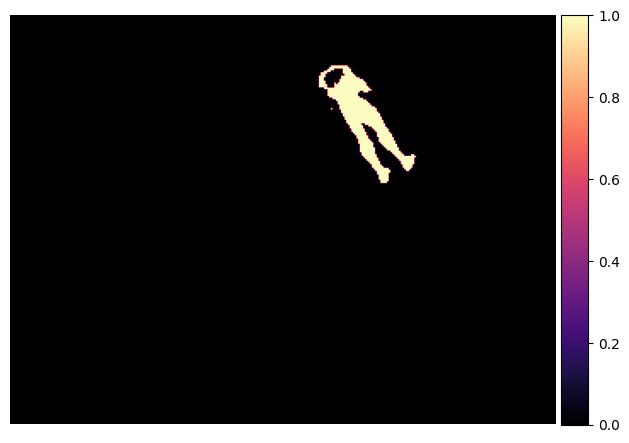

In [121]:
# MobileSAM mask
sam_masks = prediction_module.model.binary_masks

if sam_masks is None:
    print("No MobileSAM mask found")
else:
    fig, ax = plt.subplots()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    sam_mask = sam_masks.squeeze().cpu().numpy()
    img = ax.imshow(sam_mask, cmap="magma")
    ax.axis("off")
    
    # Colorbar
    fig.colorbar(img, cmap="magma", cax=cax)
    
    plt.tight_layout()
    plt.show()

In [122]:
# Module mask
predicted_probabilistic_mask = predicted_probabilistic_masks.squeeze().cpu().numpy()

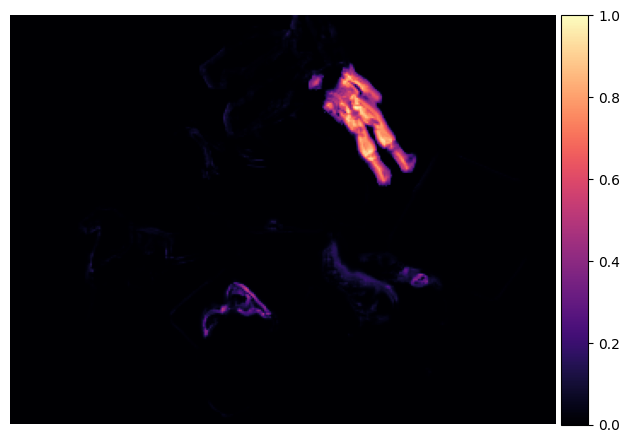

In [123]:
# Display the mask
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

# Mask
if sam_masks is None:
    # Get the image to set the color scale
    img = ax.imshow(predicted_probabilistic_mask, cmap="magma")
else:
    # Use the same color scale as the MobileSAM mask
    ax.imshow(predicted_probabilistic_mask, cmap="magma")
ax.axis("off")

# Colorbar
fig.colorbar(img, cmap="magma", cax=cax)

plt.tight_layout()
plt.show()